In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Para discretização
# from sklearn.preprocessing import KBinsDiscretizer

DATA_PATH = "../input/data/"

tsla_data = pd.read_csv(DATA_PATH + "TSLA.csv", sep=",")
tsla_ts = tsla_data[["Date", "Close"]].copy()
tsla_ts.columns = ["x", "y(x)"]
tsla_ts["x"] = pd.to_datetime(tsla_ts["x"])
tsla_ts.head(2)

,x,y(x)
0,2020-10-01,149.386673
1,2020-10-02,138.363327


In [2]:
# Calcula y(x+1) - y(x) e atribui o valor 1 ou 0
# 1: O valor é positivo
# 0: O valor é negativo
# Se for negativo, significa que o valor anterior é maior que o seu sucessor, logo uma descida
categorias = (tsla_ts["y(x)"].diff() > 0).astype(int)
# Retira o Na que foi gerado na primeira posição
categorias = categorias.dropna()

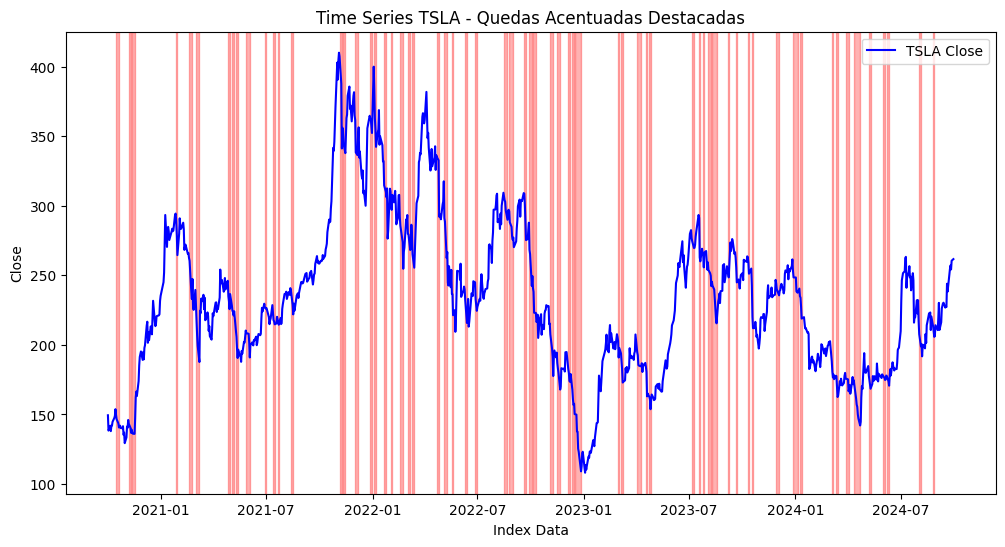

In [8]:
def encontrar_trechos_descida(series, tamanho_minimo=6):
    indices = []
    cont = 0
    for i in range(len(series)):
        if series[i] == 1:  # Interrompe a sequência
            if cont >= tamanho_minimo:
                indices.append((i - cont, i - 1))  # Salva o intervalo
            cont = 0
        else:
            cont += 1
    # Caso a série termine com uma descida longa
    if cont >= tamanho_minimo:
        indices.append((len(series) - cont, len(series) - 1))
    return indices


# Obtendo os trechos de descida acentuada
trechos = encontrar_trechos_descida(categorias.values, tamanho_minimo=3)
# Criando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(tsla_ts["x"], tsla_ts["y(x)"], label="TSLA Close", color="blue")

# Preenchendo as regiões de descida em vermelho
for inicio, fim in trechos:
    plt.axvspan(tsla_ts["x"][inicio], tsla_ts["x"][fim], color="red", alpha=0.3)

plt.xlabel("Index Data")
plt.ylabel("Close")
plt.title("Time Series TSLA - Quedas Acentuadas Destacadas")
plt.legend()
plt.show()


Sabemos que a probabilidade marginal de X e Y, onde X e Y são variáveis binárias, são dadas pelas fórmulas:

$P(X=x) = \sum_{x}P(X,Y) = P(X=x, Y=0) + P(X=x, Y=1)$

$P(Y=y) = \sum_{y}P(X,Y) = P(X=0, Y=y) + P(X=1, Y=y)$

In [4]:
transicoes = pd.DataFrame({"X": categorias[:-1].values, "Y": categorias[1:].values})
tabela_contingencia = pd.crosstab(transicoes["X"], transicoes["Y"])
p_conjunta = tabela_contingencia / tabela_contingencia.values.sum()
dados = []
for i in tabela_contingencia.index:
    for j in tabela_contingencia.columns:
        dados.append({"x": i, "y": j, "P(X=x, Y=y)": p_conjunta.loc[i, j]})

tabela_formatada = pd.DataFrame(dados)
tabela_formatada = pd.concat(
    [tabela_formatada, pd.DataFrame([{"x": "Total", "y": "", "P(X=x, Y=y)": 1}])],
    ignore_index=True,
)

display(tabela_formatada)


,x,y,"P(X=x, Y=y)"
0,0,0,0.225100
1,0,1,0.249004
2,1,0,0.248008
3,1,1,0.277888
4,Total,,1.000000


A tabela acima mostra a probabilidade de ocorrer um determinado par de valores consecutivos $(X_t,X_{t+1})$ na série temporal.

$$
P(X=0, Y=0) = 0.225100
$$
A probabilidade de haver uma queda (0) no valor atual e uma queda (0) no valor seguinte é 22,51\%.

$$
P(X=0, Y=1) = 0.249004
$$
A probabilidade de haver uma queda (0) no valor atual e uma subida (1) no valor seguinte é 24,90\%.

$$
P(X=1, Y=0) = 0.248008
$$
A probabilidade de haver uma subida (1) no valor atual e uma queda (0) no valor seguinte é 24,80\%.

$$
P(X=1, Y=1) = 0.277888
$$
A probabilidade de haver uma subida (1) no valor atual e uma subida (1) no valor seguinte é 27,79\%.



In [5]:
tabela_contingencia = pd.crosstab(transicoes["X"], transicoes["Y"])
p_conjunta = tabela_contingencia / tabela_contingencia.values.sum()
p_x = p_conjunta.sum(axis=1)
p_y = p_conjunta.sum(axis=0)
tabela_final = p_conjunta.copy()
tabela_final["P(X=x)"] = p_x
tabela_final.loc["P(Y=y)"] = p_y.tolist() + [1]

display(tabela_final)


Y,0,1,P(X=x)
X,,,
0,0.225100,0.249004,0.474104
1,0.248008,0.277888,0.525896
P(Y=y),0.473108,0.526892,1.000000
